In [3]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 4.3MB/s 
     |████████████████████████████████| 2.2MB 13.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=841c52d1710cb8b98434a516bd90137eb5eb5fe21c56f4aa2d82aa46ca772b06
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [53]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [80]:
cap = cv2.VideoCapture('/content/drive/My Drive/Colab Notebooks/old-man.mp4')

isOldMan = False
age = int(input("나이 :"))
if age >= 60 :
  isOldMan = True
  print('사용자가 구조 우선 순위로 분류되었습니다 : 노인')
address = input("당신의 주소를 입력해주세요 : ")

state = False

while(True) :
  stateInput = input("isFire ? [y / n]")
  answer = ['y', 'n']
  if not (stateInput in answer) :
    print("y 와 n 중에 입력해주세요 !")
    continue
  else :
    if stateInput == "y" :
      state = True
    elif stateInput == "n" :
      state = False
    break

if state == True :
  print("현재 상태 : 화재 발생")
  ret, frame = cap.read()
  img = frame
  print("화재 현장 실시간 이미지 정보를 가져오는 데 성공했습니다.")
else :
  print("현재 상태 : 안전")

나이 :68
사용자가 구조 우선 순위로 분류되었습니다 : 노인
당신의 주소를 입력해주세요 : 77 Jeongneung-ro, Jeongneung-dong, Seongbuk-gu, Seoul
isFire ? [y / n]y
현재 상태 : 화재 발생
화재 현장 실시간 이미지 정보를 가져오는 데 성공했습니다.


In [64]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

In [74]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0, 62], device='cuda:0')
Boxes(tensor([[ 577.6927,  322.3363,  655.2392,  397.2774],
        [1043.5188,  530.1786, 1280.0000,  717.7277]], device='cuda:0'))


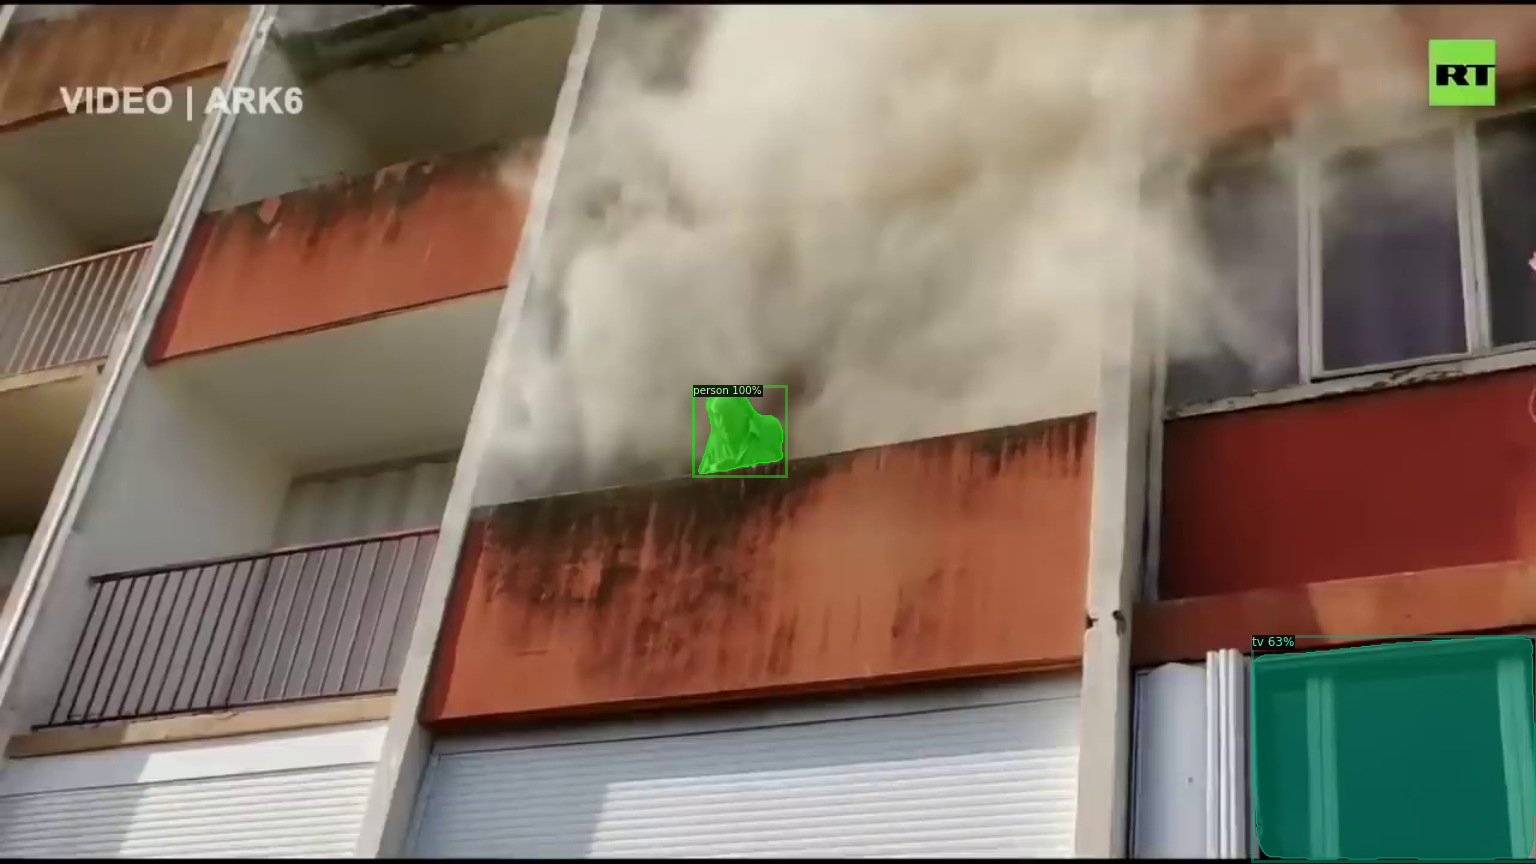

In [81]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [82]:
if (0 in outputs["instances"].pred_classes.cpu().numpy()):
  if isOldMan == True :
    print("화재 현장에 노인을 탐지했습니다.")
    print("\n주소 : " + address)
    print("우선적으로 구해주시길 바랍니다 !") 

화재 현장에 노인을 탐지했습니다.

주소 : 77 Jeongneung-ro, Jeongneung-dong, Seongbuk-gu, Seoul
우선적으로 구해주시길 바랍니다 !
